<a href="https://colab.research.google.com/github/selfor21/NLP---Natural-Language-Processing/blob/main/NLP_Intro_06_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Langue Processing

## Week 06 - Text Classification


Data from IMDB (https://ai.stanford.edu/~amaas/data/sentiment/)
Contain 50 thousand movie *reviews* (texts).
*reviews* are labeled as "Positive" or "Negative".


In [ ]:
!pip install -U "tensorflow-text==2.13.*" # executar na 1a vez
!pip install "tf-models-official==2.13.*" # executar na 1a vez
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')

## *Download* IMDB data



In [2]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84125825/84125825 [==============================] - 9s 0us/step


IMDB data already divided in train and test. It´s necessary a validation set.WE will divide training set with 80:20 ratio in order to create validation set, using argument `validation_split`.


In [3]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


Vamos dar uma olhada em algumas *reviews*.

In [6]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(4,7):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b"I thought that this was an absolutely charming movie centering around the lives of Mary-Kate's and Ashley's characters Sam and Emma Stanton! They are both trying to make both themselves and their parents happy but; unfortunately, it's just not that easy for them to actually do! I thought that this was an utterly charming and sweet movie and if you are a real fan of these marvelous young ladies then I'm sure that you'll agree with me here! If you haven't seen this movie yet then I say you really missed-out; big time, and that you should definitely take the time out to see it now! This movie is a real winner! Sincerely, Rick Morris"
Label : 1 (pos)
Review: b"The filming is pleasant and the environment is keenly realistic. I liked that it boldly redresses conceptions of the many difficult moral and social morays of the 1930's Chinese-mainland countryside as well as more basic human questions - I felt I could get a real sense of the times, recreated even in splendid shots of trad

##Transformers e BERT

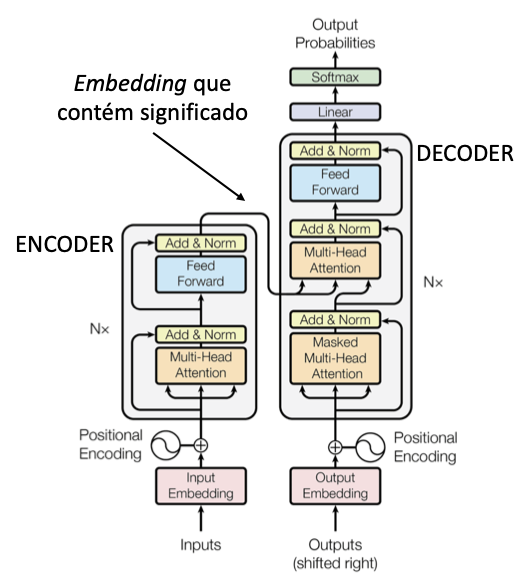

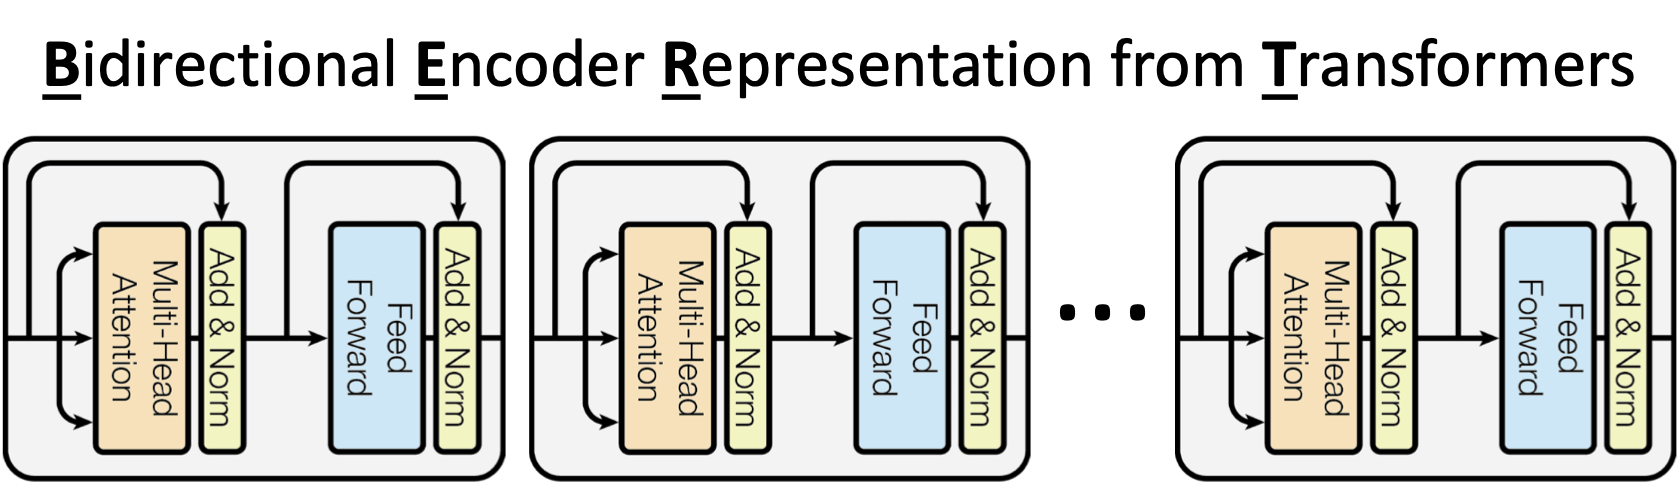

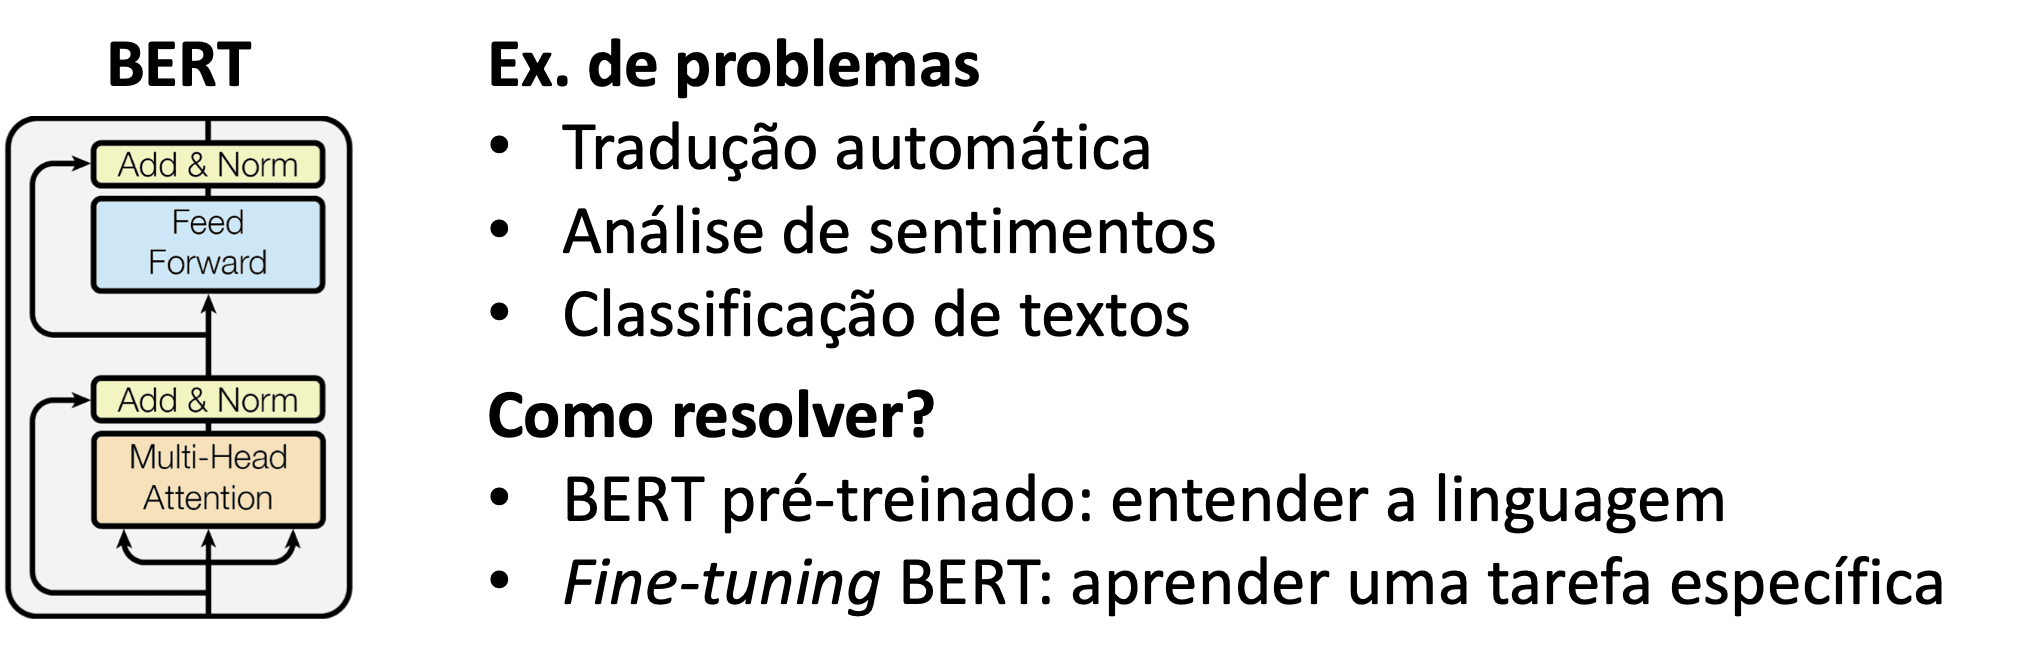

In [7]:
#@title ## Pre-tranied BERT model selection (TensorFlow Hub)

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
#bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT selection           : {tfhub_handle_encoder}')
print(f'Pre-processing auto-selection: {tfhub_handle_preprocess}')

BERT selection           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pre-processing auto-selection: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## Pre-processing Model

Text input needs to be numerical *token* IDs and formated as tensors prior BERT input. TensorFlow Hub offers a pre-processing model correspondent to each BERT model.

Obs: pre-processing model at [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer).

In [8]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Vamos testar o modelo de pré-processamento em alguns textos e ver a saída.

In [9]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


Output of pre-processing from a BERT model BERT:
(`input_words_id`, `input_mask` e `input_type_ids`).

Highlights:
- Input size up to 128 *tokens*.
- `input_type_ids has value (0). It´s a single phrase input. For multiple sentence input´s, one value to each input.



## Utilizando o modelo BERT

Antes de inserir o BERT no nosso modelo, vamos dar uma olhada em suas saídas. Vamos carregá-lo do TF Hub e ver os valores retornados.

In [10]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [11]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262873  0.9928099  -0.18611872  0.36673853  0.1523371   0.65504426
  0.9681154  -0.94862705  0.00216182 -0.9877732   0.06842728 -0.97630584]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946307  0.34321266  0.33231518 ...  0.21300897  0.71020764
  -0.05771176]
 [-0.2874206   0.3198098  -0.23018597 ...  0.5845501  -0.21329726
   0.72692066]
 [-0.6615712   0.68876785 -0.8743292  ...  0.10877268 -0.2617322
   0.4785534 ]
 ...
 [-0.22561154 -0.28925663 -0.07064398 ...  0.47566003  0.8327717
   0.40025344]
 [-0.29824272 -0.27473173 -0.05450511 ...  0.48849759  1.0955356
   0.18163322]
 [-0.44378266  0.00930682  0.07223728 ...  0.17290092  1.1833241
   0.07898061]]


BERT models returns 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each sequence. Dimensions are`[batch_size, H]`. It´s like an *embedding* to the *review*.
- `sequence_output` represents each input *token*. Dimensions are `[batch_size, seq_length, H]`. It´s like an contextual *embedding* to each *token* for *review* from movie.
- `encoder_outputs` are intermediate activations from Transformer blocks `L`. `outputs["encoder_outputs"][i]` is a Tensor with dimensions `[batch_size, seq_length, 1024]` with i-nth Transformer block outpu, for  `0 <= i < L`. Last value is equal to 'sequence_output`.

For *fine-tuning* (ajuste fino), we will use array `pooled_output`.

## Definindo o modelo

Vamos criar um modelo ajustado muito simples, com o modelo de pré-processamento, o modelo BERT selecionado, uma camada densa e uma camada de Dropout.

In [12]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Vamos dar uma olhada no modelo.

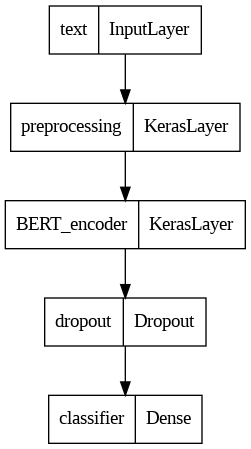

In [13]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

## Treinando o modelo

Agora, temos todas as peças para treinar um modelo, incluindo o módulo de pré-processamento, codificador BERT, dados e classificador.

### Função de perda (*Loss function*)

Como este é um problema de classificação binária e o modelo gera uma probabilidade (uma camada de unidade única), podemos usar a função de perda `losses.BinaryCrossentropy`.


In [14]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Otimizador

Para o *fine-tuning*, vamos usar o mesmo otimizador com o qual o BERT foi originalmente treinado: o "Adaptive Moments" (Adam).

Para a taxa de aprendizado (`init_lr`), você usará o mesmo cronograma do pré-treinamento do BERT: decaimento linear da taxa de aprendizado inicial, prefixada com uma fase de aquecimento linear nos primeiros 10% das etapas de treinamento (`num_warmup_steps `). De acordo com o artigo do BERT, a taxa de aprendizado inicial é menor para o ajuste fino (melhor de 5e-5, 3e-5, 2e-5).

In [15]:
epochs = 5 # treinar pelo menos 5 épocas, mas demora
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Carregando e treinando o modelo BERT

Usando o `classifier_model` criado anteriormente, podemos compilar o modelo com o *loss* (perda), métrica e otimizador escolhidos.

In [16]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Aplicando o modelo antes do treinamento (*fine-tunning*)

In [17]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 100s 127ms/step - loss: 0.7015 - binary_accuracy: 0.5347
Loss: 0.7015188932418823
Accuracy: 0.5346800088882446


O tempo de treinamento varia de acordo com a complexidade do modelo BERT selecionado.

In [18]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 175s 271ms/step - loss: 0.4820 - binary_accuracy: 0.7459 - val_loss: 0.3662 - val_binary_accuracy: 0.8370
Epoch 2/5
625/625 [==============================] - 168s 268ms/step - loss: 0.3233 - binary_accuracy: 0.8547 - val_loss: 0.3707 - val_binary_accuracy: 0.8398
Epoch 3/5
625/625 [==============================] - 167s 267ms/step - loss: 0.2422 - binary_accuracy: 0.8992 - val_loss: 0.4081 - val_binary_accuracy: 0.8422
Epoch 4/5
625/625 [==============================] - 168s 268ms/step - loss: 0.1891 - binary_accuracy: 0.9251 - val_loss: 0.4290 - val_binary_accuracy: 0.8506
Epoch 5/5
625/625 [==============================] - 169s 271ms/step - loss: 0.1467 - binary_accuracy: 0.9456 - val_loss: 0.4755 - val_binary_accuracy: 0.8526


## Avaliando o modelo

Vamos ver como o modelo se comporta para classificar textos (reviews) não utilizadas no treinamento.

Dois valores serão retornados. *Loss* (quanto menor, melhor) e acurácia (quanto maior, melhor).

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 132s 169ms/step - loss: 0.4527 - binary_accuracy: 0.8550
Loss: 0.45273399353027344
Accuracy: 0.8550000190734863


### Visualizando Acurácia e Loss ao longo do treinamento

Baseado no objeto `History` retornado por `model.fit()`, podemos visualizar os valores de *loss* e acurácia de treinamento e validação.

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


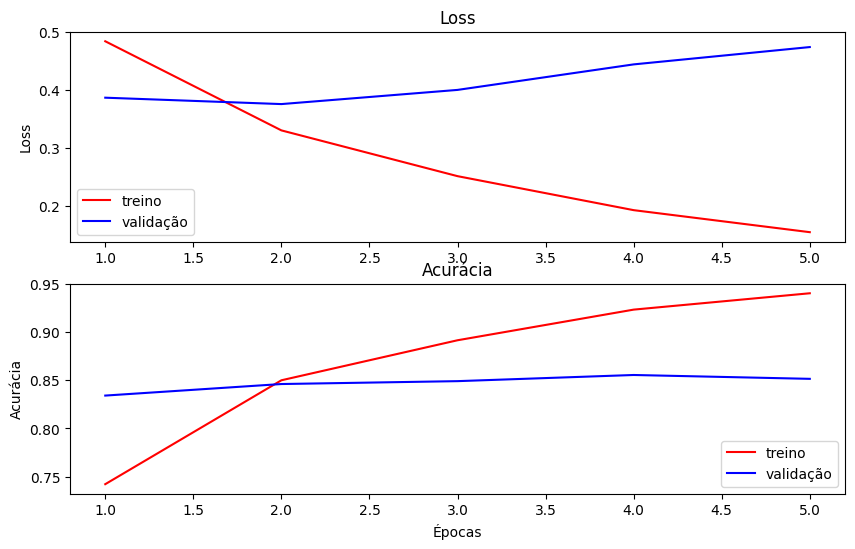

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='treino')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='validação')
plt.title('Loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='treino')
plt.plot(epochs, val_acc, 'b', label='validação')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend(loc='lower right')

## Salvando o modelo ajustado


In [ ]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))
classifier_model.save(saved_model_path, include_optimizer=False)

Podemos recarregar o modelo salvo e comparar os resultados com os que ainda estão na memória.

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Resultados do modelo salvo:')
print_my_examples(examples, reloaded_results)
print('Resultados do modelo na memória:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.982189
input: The movie was great!           : score: 0.924239
input: The movie was meh.             : score: 0.652437
input: The movie was okish.           : score: 0.310212
input: The movie was terrible...      : score: 0.067813

Results from the model in memory:
input: this is such an amazing movie! : score: 0.982189
input: The movie was great!           : score: 0.924239
input: The movie was meh.             : score: 0.652437
input: The movie was okish.           : score: 0.310212
input: The movie was terrible...      : score: 0.067813





https://www.tensorflow.org/text/tutorials/classify_text_with_bert

https://www.tensorflow.org/tutorials/keras/text_classification
